In [ ]:
#export
import torch
import torch.nn as nn
from fastai.vision.all import *
from fastai.data.all import *
from fastai.distributed import *
import pandas as pd
from pathlib import Path
import time
from vidaug import augmentors as va

import torchvision.transforms as T


from modules_th.video_block import * 
from modules_th.inflator import *
from modules_th.triplet_loss import *
from modules_th.supcon_module import *
from modules_th.cus_cbs import *

#Pretrained models
from modules_th.pretrained_r2p1d50 import *
from resnetmodels.mean import get_mean_std

In [ ]:
#export
def read_data():
    prefix = '/mnt/data/eugeniomarinelli/'
    items_path = prefix + 'videodata/ucf101.csv'
    return pd.read_csv(items_path, index_col=0)ipython-input-15-ca61b3aa75fc> in <module>
----> 

In [ ]:
df = read_data()
df.head()

,vid_files,lbls,val
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi,ApplyEyeMakeup,1
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi,ApplyEyeMakeup,1
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c03.avi,ApplyEyeMakeup,1
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c04.avi,ApplyEyeMakeup,1
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c05.avi,ApplyEyeMakeup,1


In [ ]:
#export
def get_dsets(df, l=40, size=512,skip=20,n_views=2):
    vid_paths = df.vid_files.values
    prefix = Path('/mnt/data/eugeniomarinelli/videodata/UCF-101/')
    vid_paths = [prefix/file for file in vid_paths]
    
    sometimes = lambda x:va.Sometimes(0.5,x)
    vid_pip = [createVideoForm(l=l,skip=skip, form='img'), 
               Resize(size, method=ResizeMethod.Pad),
               sometimes(va.HorizontalFlip()),
               va.GaussianBlur(1.),
               sometimes(va.InvertColor()),
               va.RandomRotate(10),
               lambda x: Video(x)]

    lbl_pip = [parent_label, Categorize()]           
    pip = [*([vid_pip]*n_views), lbl_pip]
    #splits
    splits = ColSplitter('val')(df)

    # Datasets and dataloaders
    dsets = Datasets(vid_paths, pip, splits=splits)
    return dsets, splits
    

In [ ]:
dsets,splits = get_dsets(df)
vid = dsets[0][0]

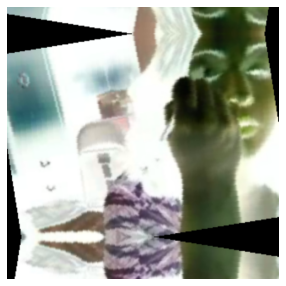

In [ ]:
vid.show()

In [ ]:
# export
def get_dls(dsets,splits,df, n_el= 4, n_lbl = 2, shuffle_fn= UniformizedShuffle, normalize='kinetics'):
        
    mean, std = get_mean_std(1,normalize)
    dls  = dsets.dataloaders(bs=n_el*n_lbl, 
                             shuffle_train=True,
                             after_item=ToTensor(),
                             after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)])
    
    dls.valid.shuffle = True
    if shuffle_fn is not None:
        dls.train.shuffle_fn = UniformizedShuffle(df.lbls.iloc[splits[0]], n_el = n_el, n_lbl= n_lbl)
        dls.valid.shuffle_fn = UniformizedShuffle(df.lbls.iloc[splits[1]], n_el = n_el, n_lbl= n_lbl)
    return dls
    

In [ ]:
dls = get_dls(dsets,splits,df, normalize='kinetics')


In [ ]:
#export
def setup_log(learn,name):
     # set up logs file
    # now = datetime.now()
    # time = now.strftime("%d_%m")
    logs_file = '/mnt/data/eugeniomarinelli/UCF_experiments/training_results/logs_ucf101_'+name+'.csv'
    Logs_csv =   CSVLogger(fname= logs_file, append=False)    
    learn.add_cb(Logs_csv)

In [ ]:
#export
def get_learner(df,
                pretrained_model='r2p1d50_K',  
                loss='CEL-SCL', 
                l=40, size=224, n_lbl =4, n_el=2, skip=20, embs_size=128,n_views=2, 
                normalize = 'kinetics'):

    dsets,splits = get_dsets(df, l, size, skip, n_views)

    dls = get_dls(dsets,splits,df, normalize=normalize)
    
    if pretrained_model in inserted_models:
        model = inserted_models[pretrained_model]
    else: raise 'model not present in pretrained models'
       
    body = create_body(model, cut=-2)
    
        


    if loss == 'CEL-SCL':
        Loss = SumLoss(SupConLoss,p='cos', alpha=1, n_views=n_views)
        head = inflate(create_head(4096, len(dls.vocab), lin_ftrs=[embs_size]))
        model = AnomalyDetectionModel(body,head)
        metrics = [supcon_accuracy, silh_score]
        
        
    elif loss == 'SCL':
        Loss= SupConLoss() 
        head = inflate(create_head(4096, embs_size, lin_ftrs=[] ))
        model = nn.Sequential(body,head)
        metrics = [silh_score]
        
        
    elif loss == 'CEL':
        Loss = CrossEntropyLossFlat()
        head = inflate(create_head(4096, len(dls.vocab), lin_ftrs=[]))
        model = nn.Sequential(body,head)
        metrics = [supcon_accuracy,silh_score]
        
    else :
        raise 'Loss not implemented'
        
    
        
    learn = Learner(dls, 
                model,
                splitter=splitter ,
                loss_func=Loss,
                metrics=metrics)
    
    if loss == 'CEL-SCL':
        learn.add_cbs([ContrastiveCallback(n_views)])#,LossesRecorderCallback()])
    elif loss in ['SCL', 'CEL']:
        learn.add_cb(ContrastiveCallback(n_views))
        
    setup_log(learn, str(pretrained_model)+loss)
   
    return learn
 

In [ ]:
learn = get_learner(df, 'r2p1d50_K', loss='SCL', l=2, size=224, n_lbl =4, n_el=2, skip=20, embs_size=128,n_views=2  )


loading pretrained model /mnt/data/eugeniomarinelli/pretrained/r2p1d50_K_200ep.pth


In [ ]:
#export
def save_learner(learn, name):
    prefix = '/mnt/data/eugeniomarinelli/'
    learn.save(prefix+'UCF_experiments/trained_models_cnn/ucf101_our_model_'+name)
    learn.export(prefix+'UCF_experiments/trained_models_cnn/ucf_cnn_'+name+'learner')

    experiment = pd.DataFrame({'date':time,
             'description':[descr],
             'l':[l],
             'skip':[skip],
             'size':[size],
             'loss':[loss],
             'n_el':[n_el],
             'n_lbl':[n_lbl],
             'n_epochs':[n_epoch]}).to_csv(prefix+'UCF_experiments/experiments_logs.csv', mode='a', header=False)

In [ ]:
learn.fine_tune(1)

In [ ]:
from nbdev.export import *
notebook2script()

NotJSONError: Notebook does not appear to be JSON: '{\n "cells": [\n  {\n   "cell_type": "c...

In [ ]:
#default_exp ucf101

In [ ]:
import os


In [ ]:
df_train = pd.read_csv('/mnt/data/eugeniomarinelli/videodata/ucfTrainTestlist/trainlist01.txt',sep=' ', header = None).drop(columns=[1])<AxesSubplot:>
df_test = pd.read_csv('/mnt/data/eugeniomarinelli/videodata/ucfTrainTestlist/testlist01.txt',sep=' ', header = None)

In [ ]:
df_test.columns = ['vid_files']
df_train.columns = ['vid_files']

In [ ]:
df = df_test.append(df_train)

In [ ]:
prefix

Path('/mnt/data/eugeniomarinelli/videodata/UCF-101')